## Import the necessary libraries

In [62]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os


In [2]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=6336ccd6e4d19588b76c23f96b65c7af4a7e38574a31053f1ce2f55e611d2e61
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [3]:
pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 56.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.5 MB/s eta 0:00:00


In [4]:
from sklearn.metrics import ConfusionMatrixDisplay

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, wget
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from wordcloud import WordCloud
wget.download("https://raw.githubusercontent.com/yogawicaksana/helper_prabowo/main/helper_prabowo_ml.py",out="helper_prabowo_ml.py")


from helper_prabowo_ml import clean_html, remove_links, remove_special_characters, removeStopWords, remove_, remove_digits, lower, email_address, non_ascii, punct, hashtags
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Updating the default configuration

In [6]:
plt.rcParams['figure.figsize'] = (12,8)

## Loading the dataset

In [7]:
df = pd.read_csv("/content/Language Detection.csv")
df = df.sample(frac=1)
df.head()

,Text,Language
1434,അതിനാൽ വിക്കിപീഡിയയിലെ ഉള്ളടക്കം എല്ലാക്കാലവും...,Malayalam
10052,ಯಾರಾದರೂ ತಂಪಾದ ಹಾಸ್ಯವನ್ನು ಹೇಳಿದರೆ ಅದು ಒಳ್ಳೆಯದು ...,Kannada
10012,ಸಾಧ್ಯವಾಗಲಿಲ್ಲ.,Kannada
5046,Todos ellos son también multilingües y libres ...,Spanish
8123,tanıştığıma memnun oldum.,Turkish


## Feature Engineering

In [8]:
df.shape

(10337, 2)

In [9]:
df.Language.unique()

array(['Malayalam', 'Kannada', 'Spanish', 'Turkish', 'Arabic', 'English',
       'Tamil', 'French', 'Italian', 'Dutch', 'Danish', 'Portugeese',
       'German', 'Russian', 'Sweedish', 'Greek', 'Hindi'], dtype=object)

In [10]:
df.Language.replace(to_replace=['Portugeese','Sweedish'],value=['Portuguese','Swedish'],inplace=True)

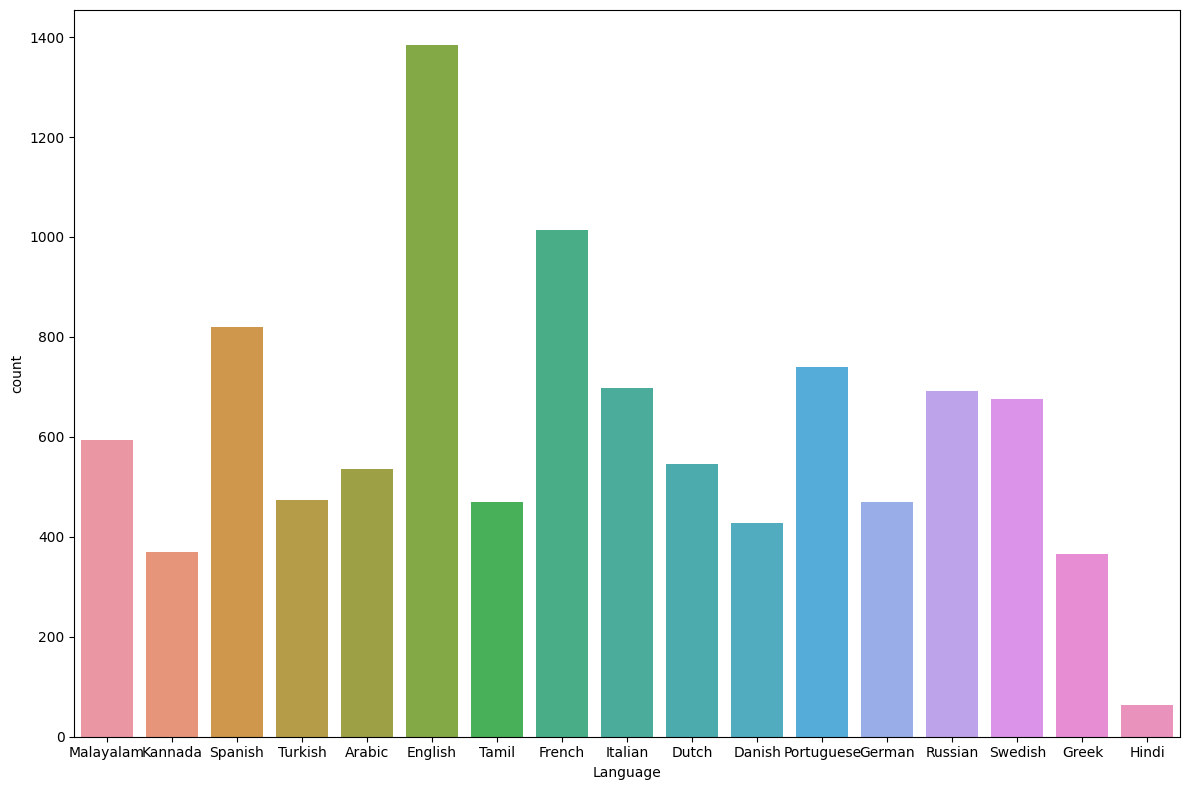

In [11]:
sns.countplot(data=df, x='Language')
plt.tight_layout()
plt.show()

In [12]:
#sns.countplot(df.Language)
#plt.tight_layout();

In [13]:
df.isnull().sum()

Text        0
Language    0
dtype: int64

In [14]:
df.shape

(10337, 2)

In [15]:
#df = df[df.Language.isin(["English","French","Dutch","Spanish","Danish","Italian","Swedish","German","Portuguese","Turkish"])]
#df.shape

In [16]:
df = df[df.Language.isin(["English","French","Dutch","Spanish","Danish","Italian","Swedish","German","Portuguese","Turkish"])]
df.shape

(7249, 2)

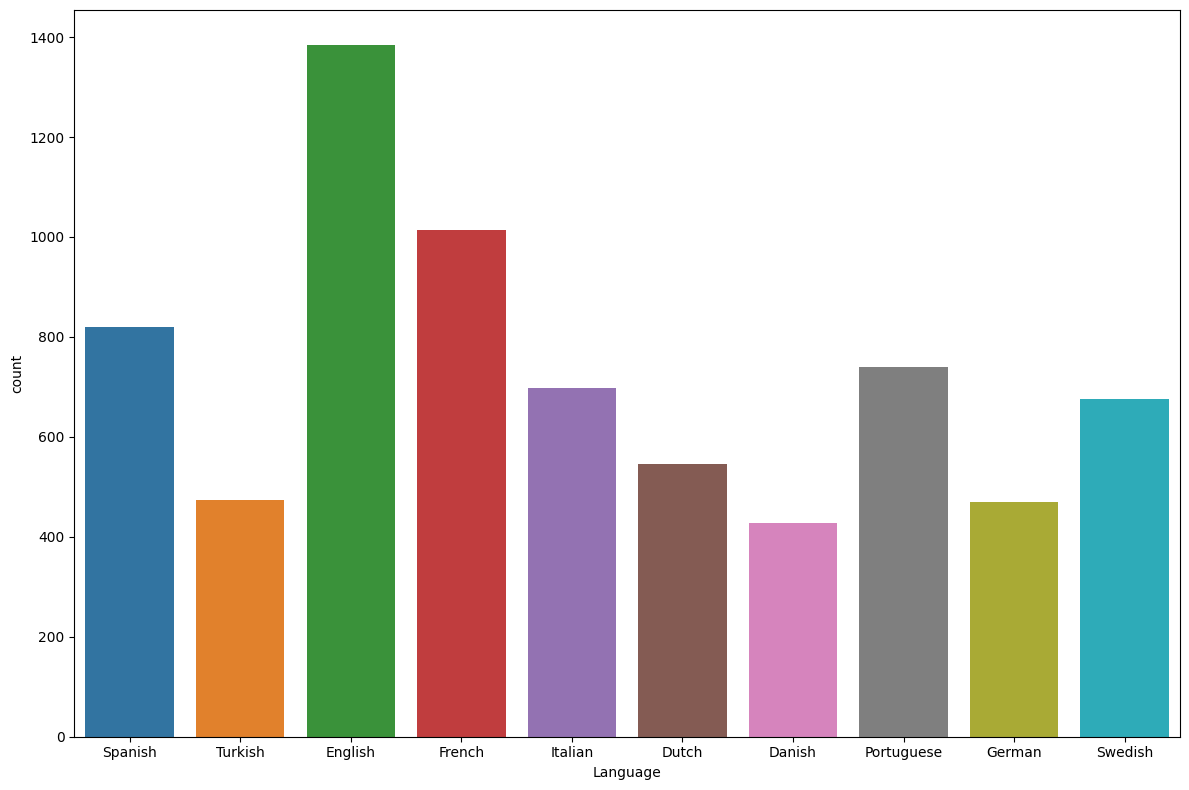

In [17]:
sns.countplot(data=df, x='Language')
plt.tight_layout()
plt.show()

The target language classes are considerably imbalanced so they need to be accounted for later.

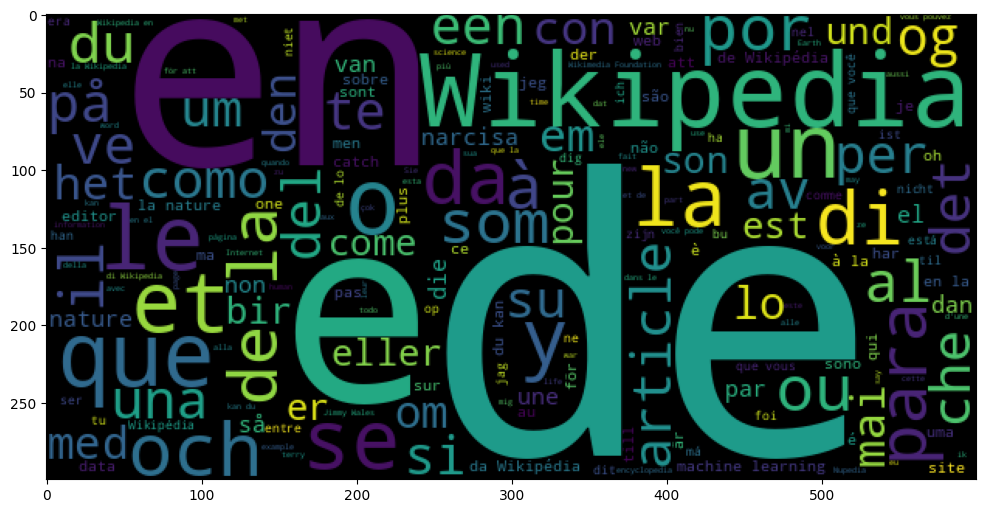

In [18]:
wc = WordCloud(width=600,height=300,random_state=42).generate(' '.join(df.Text))
plt.imshow(wc);

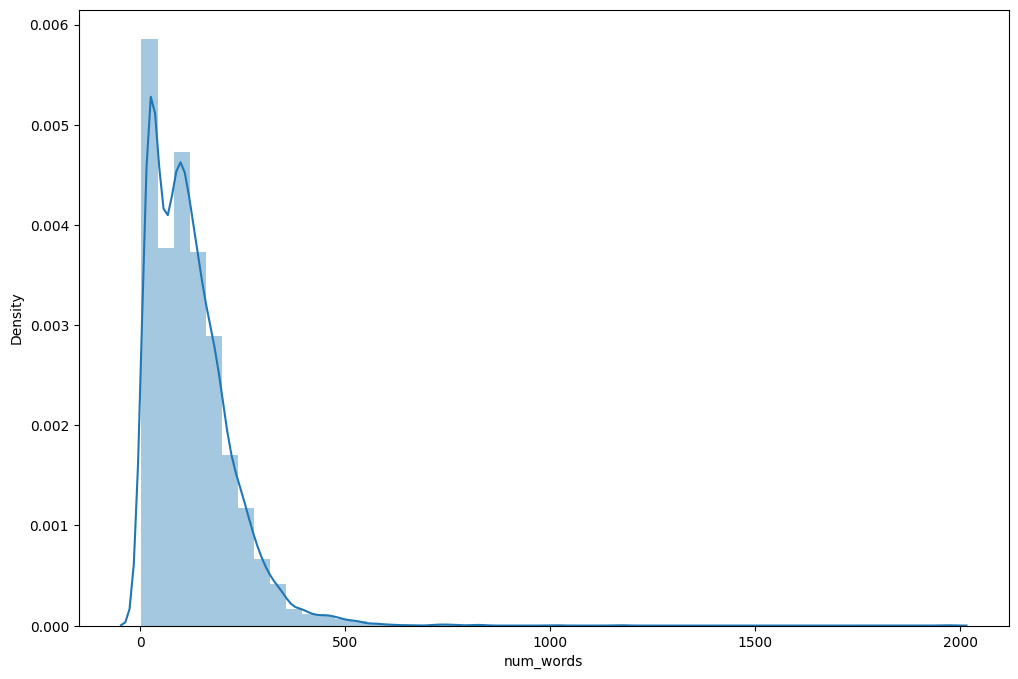

In [19]:
df['num_words'] = df.Text.apply(len)
sns.distplot(df.num_words);

In [20]:
df['num_words'].max()

1965

In [21]:
df.num_words.describe()

count    7249.000000
mean      123.570010
std        98.117023
min         3.000000
25%        48.000000
50%       106.000000
75%       173.000000
max      1965.000000
Name: num_words, dtype: float64

In [38]:
max_len = 125

## Text Preprocessing

In [23]:
def text_preprocess(data,col):
    data[col] = data[col].apply(func=clean_html)
    data[col] = data[col].apply(func=remove_)
    data[col] = data[col].apply(func=removeStopWords)
    data[col] = data[col].apply(func=remove_digits)
    data[col] = data[col].apply(func=remove_links)
    data[col] = data[col].apply(func=remove_special_characters)
    data[col] = data[col].apply(func=punct)
    data[col] = data[col].apply(func=non_ascii)
    data[col] = data[col].apply(func=email_address)
    data[col] = data[col].apply(func=lower)
    return data

In [24]:
preprocessed_df = text_preprocess(df,'Text')
preprocessed_df.head()

,Text,Language,num_words
5046,todos ellos son tambin multilinges libres estn...,Spanish,95
8123,tantma memnun oldum,Turkish,25
838,each training example one inputs desired outpu...,English,104
3897,selon le journal science fin les effets sur l ...,French,166
7755,mi dispiace davvero,Italian,20


## Encoding the target label classes

In [25]:
labels_dict = {}
for idx, lang in enumerate(preprocessed_df.Language.unique()):
    labels_dict[lang] = idx
labels_dict

{'Spanish': 0,
 'Turkish': 1,
 'English': 2,
 'French': 3,
 'Italian': 4,
 'Dutch': 5,
 'Danish': 6,
 'Portuguese': 7,
 'German': 8,
 'Swedish': 9}

In [26]:
preprocessed_df['Label'] = preprocessed_df.Language.map(labels_dict)
preprocessed_df.head()

,Text,Language,num_words,Label
5046,todos ellos son tambin multilinges libres estn...,Spanish,95,0
8123,tantma memnun oldum,Turkish,25,1
838,each training example one inputs desired outpu...,English,104,2
3897,selon le journal science fin les effets sur l ...,French,166,3
7755,mi dispiace davvero,Italian,20,4


In [27]:
#Shuffle the rows of a DataFrame named preprocessed_df randomly. Shuffling the rows can be useful for tasks like splitting data into training and validation sets or ensuring randomness in your data before certain analyses.

In [28]:
preprocessed_df.sample(frac=1)

,Text,Language,num_words,Label
8032,zgnm diyebilirsiniz,Turkish,23,1
8865,jag r upptagen morgon,Swedish,25,9
777,the term machine learning coined arthur samuel...,English,157,2
7091,hvad hej jeg er kommet bede om narcissus gtesk...,Danish,110,6
684,he said lack freedom forced wikipedia the seve...,English,209,2
...,...,...,...,...
385,statistical analyses suggest committee ignores...,English,332,2
8947,got annat men jag vill ha normalt brdbrd som j...,Swedish,184,9
8904,jag har rtt med dig,Swedish,21,9
2787,em sua ideia original wikipdia tinha sido feit...,Portuguese,192,7


## Splitting the preprocessed dataset into train and test sets

In [29]:
train_df, test_df = train_test_split(preprocessed_df,test_size=0.3,random_state=42,shuffle=True,stratify=preprocessed_df.Language)

## Downloading the pretrained tokenizer and xlm-roberta-base language detection model

In [30]:
tokenizer = AutoTokenizer.from_pretrained("papluca/xlm-roberta-base-language-detection")
xlm = TFAutoModelForSequenceClassification.from_pretrained("papluca/xlm-roberta-base-language-detection",from_pt=True)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFXLMRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFXLMRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaForSequenceClassification for predictions without further training.


## Performing text tokenization

In [49]:
X_train = tokenizer(text=train_df.Text.tolist(),
                   max_length=max_len,
                   padding=True,
                   truncation=True,
                   add_special_tokens=True,
                   return_tensors="tf",
                   return_attention_mask=True,
                   return_token_type_ids=False,
                   verbose=True)

X_test = tokenizer(text=test_df.Text.tolist(),
                  max_length=max_len,
                  padding=True,
                  truncation=True,
                  add_special_tokens=True,
                  return_tensors="tf",
                  return_attention_mask=True,
                  return_token_type_ids=False,
                  verbose=True)

## Fine-tuning the pretrained xlm-roberta-base language detection model

In [50]:
input_ids = Input(shape=(max_len,),dtype=tf.int32,name='input_ids')
attention_mask = Input(shape=(max_len,),dtype=tf.int32,name='attention_mask')

In [51]:
embeddings = xlm(input_ids,attention_mask=attention_mask)[0] # 0 --> final hidden state, 1 --> pooling output
output = Flatten()(embeddings)
output = Dense(units=1024,activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=512,activation='relu')(output)
output = Dropout(0.2)(output)
output = Dense(units=128,activation='relu')(output)
output = Dense(units=10,activation='softmax')(output)

model = Model(inputs=[input_ids,attention_mask],outputs=output)
model.layers[2].trainable = True

## Model Architecture

In [52]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 125)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 125)]        0           []                               
                                                                                                  
 tfxlm_roberta_for_sequence_cla  TFSequenceClassifie  278059028  ['input_ids[0][0]',              
 ssification (TFXLMRobertaForSe  rOutput(loss=None,               'attention_mask[0][0]']         
 quenceClassification)          logits=(None, 20),                                                
                                 hidden_states=None                                         

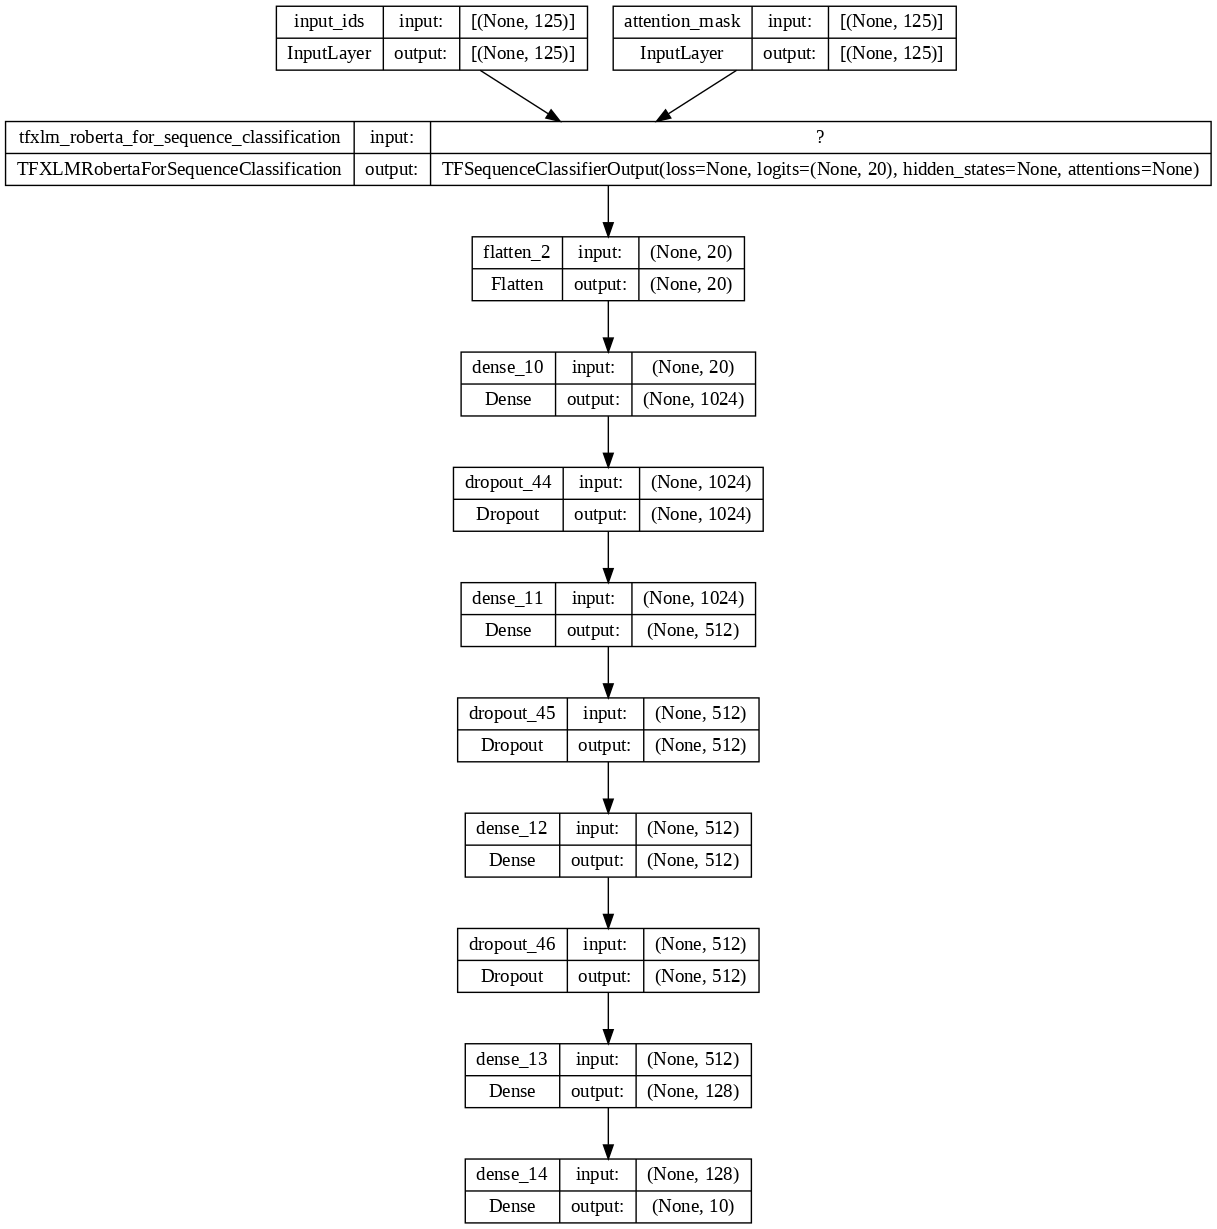

In [53]:
plot_model(model,'model.png',show_shapes=True,dpi=100,rankdir='TB')

## Compiling the model

In [55]:
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=5e-5,epsilon=2e-8,decay=0.01,clipnorm=1.0)
loss = CategoricalCrossentropy()
metrics = CategoricalAccuracy('balanced_accuracy')
model.compile(loss=loss,optimizer=optimizer,metrics=metrics)

## Training the fine-tuned XLM-Roberta-Base transformer model

In [56]:
es = EarlyStopping(monitor='val_balanced_accuracy',patience=20,verbose=1,mode='max',restore_best_weights=True)
mc = ModelCheckpoint(filepath='checkpoint',monitor='val_balanced_accuracy',mode='max',save_best_only=True,verbose=1)

r = model.fit(x={'input_ids': X_train['input_ids'], 'attention_mask': X_train['attention_mask']},
              y=to_categorical(train_df.Label),
              epochs=5,
              batch_size=20,
              callbacks=[es,mc],
              validation_data=({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
             )

Epoch 1/5
254/254 [==============================] - ETA: 0s - loss: 0.6075 - balanced_accuracy: 0.8636
Epoch 1: val_balanced_accuracy improved from -inf to 0.98161, saving model to checkpoint


254/254 [==============================] - 285s 1s/step - loss: 0.6075 - balanced_accuracy: 0.8636 - val_loss: 0.1066 - val_balanced_accuracy: 0.9816
Epoch 2/5
254/254 [==============================] - ETA: 0s - loss: 0.0958 - balanced_accuracy: 0.9823
Epoch 2: val_balanced_accuracy improved from 0.98161 to 0.98391, saving model to checkpoint


254/254 [==============================] - 330s 1s/step - loss: 0.0958 - balanced_accuracy: 0.9823 - val_loss: 0.0853 - val_balanced_accuracy: 0.9839
Epoch 3/5
254/254 [==============================] - ETA: 0s - loss: 0.0699 - balanced_accuracy: 0.9848
Epoch 3: val_balanced_accuracy did not improve from 0.98391
254/254 [==============================] - 171s 672ms/step - loss: 0.0699 - balanced_accuracy: 0.9848 - val_loss: 0.0812 - val_balanced_accuracy: 0.9839
Epoch 4/5
254/254 [==============================] - ETA: 0s - loss: 0.0600 - balanced_accuracy: 0.9874
Epoch 4: val_balanced_accuracy did not improve from 0.98391
254/254 [==============================] - 171s 672ms/step - loss: 0.0600 - balanced_accuracy: 0.9874 - val_loss: 0.0948 - val_balanced_accuracy: 0.9811
Epoch 5/5
254/254 [==============================] - ETA: 0s - loss: 0.0411 - balanced_accuracy: 0.9913
Epoch 5: val_balanced_accuracy improved from 0.98391 to 0.98483, saving model to checkpoint


254/254 [==============================] - 385s 2s/step - loss: 0.0411 - balanced_accuracy: 0.9913 - val_loss: 0.0955 - val_balanced_accuracy: 0.9848


In [46]:
X_train['input_ids'].shape

TensorShape([5074, 150])

In [47]:
X_train['attention_mask'].shape

TensorShape([5074, 150])

In [48]:
max_len

125

## Analyzing the overall performance of trained model

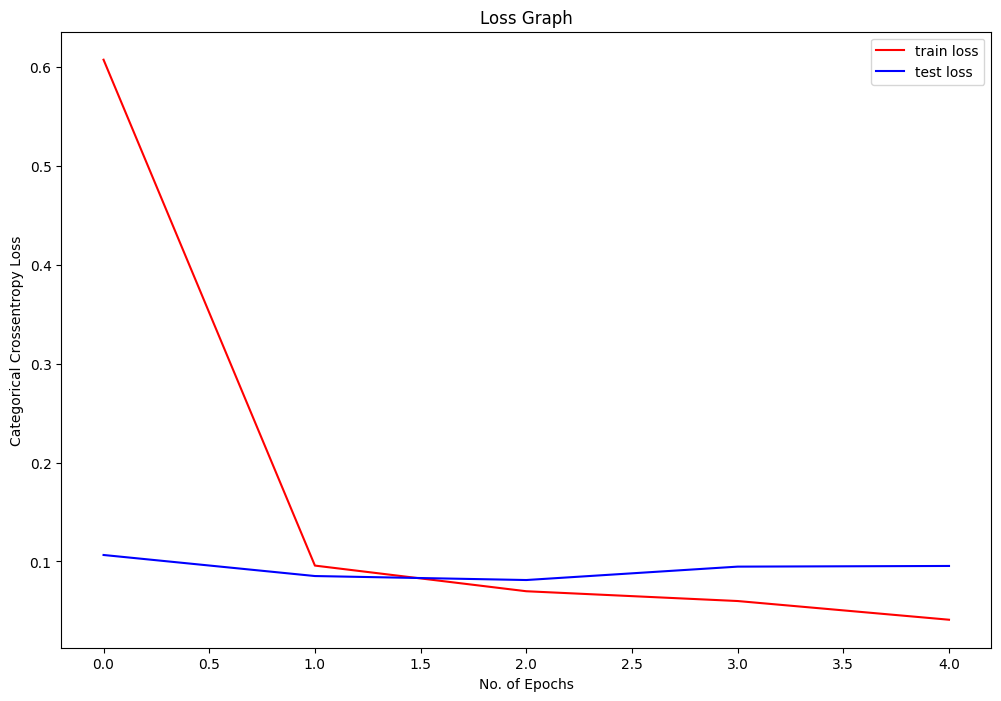

In [57]:
plt.plot(r.history['loss'],'r',label='train loss')
plt.plot(r.history['val_loss'],'b',label='test loss')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Crossentropy Loss')
plt.title('Loss Graph')
plt.legend();

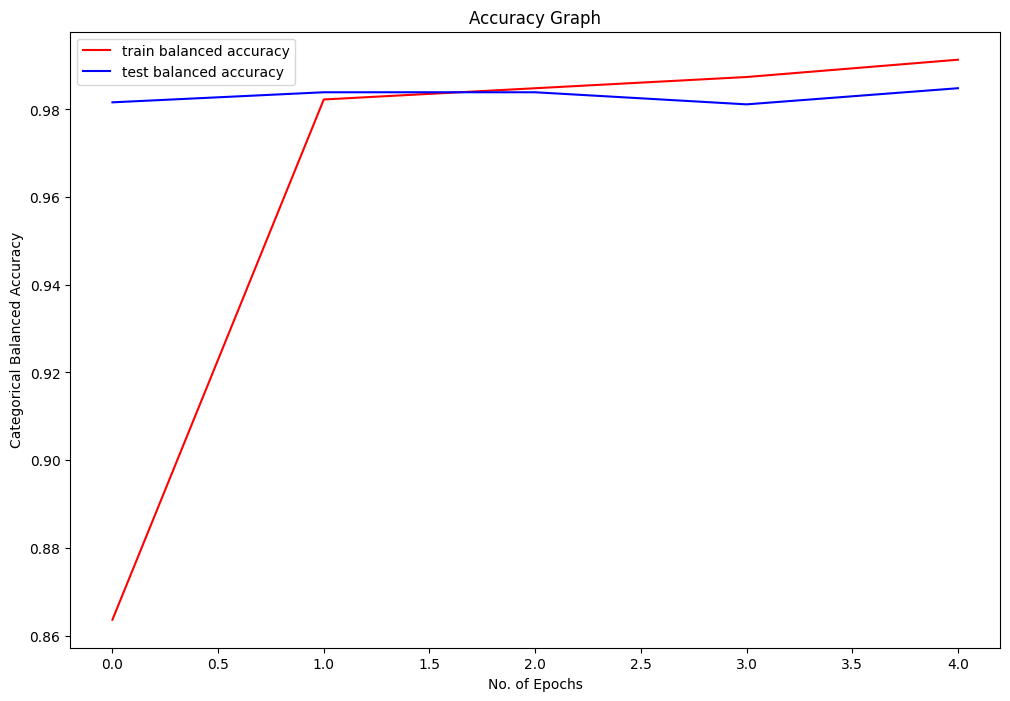

In [58]:
plt.plot(r.history['balanced_accuracy'],'r',label='train balanced accuracy')
plt.plot(r.history['val_balanced_accuracy'],'b',label='test balanced accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Categorical Balanced Accuracy')
plt.title('Accuracy Graph')
plt.legend();

## Saving the model

In [59]:
model.save('language_detector.h5')

## Model Evaluation

In [60]:
loss, acc = model.evaluate({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']},to_categorical(test_df.Label))
print("Categorical Cross-entropy Loss:", loss)
print("Categorical Accuracy:", acc)

68/68 [==============================] - 18s 260ms/step - loss: 0.0955 - balanced_accuracy: 0.9848
Categorical Cross-entropy Loss: 0.09545346349477768
Categorical Accuracy: 0.9848275780677795


In [61]:
test_predictions = model.predict({'input_ids': X_test['input_ids'], 'attention_mask': X_test['attention_mask']})
test_predictions = np.argmax(test_predictions,axis=1)
print("Confusion Matrix:")
print(confusion_matrix(test_df.Label,test_predictions))
print('-----------------------------')
print("Encoded Labels:")
print(labels_dict)
print('-----------------------------')
print("Classification Report:")
print(classification_report(test_df.Label,test_predictions))

68/68 [==============================] - 20s 255ms/step
Confusion Matrix:
[[235   1   1   2   4   0   0   3   0   0]
 [  0 138   0   1   0   0   2   0   1   0]
 [  0   0 413   0   1   0   0   1   0   1]
 [  0   0   2 300   1   0   0   0   1   0]
 [  2   0   0   0 206   0   0   1   0   0]
 [  0   0   3   0   0 160   0   0   1   0]
 [  0   0   0   1   0   0 125   0   0   2]
 [  0   0   0   1   0   0   0 221   0   0]
 [  0   0   0   0   0   0   0   0 141   0]
 [  0   0   0   0   0   0   0   0   0 203]]
-----------------------------
Encoded Labels:
{'Spanish': 0, 'Turkish': 1, 'English': 2, 'French': 3, 'Italian': 4, 'Dutch': 5, 'Danish': 6, 'Portuguese': 7, 'German': 8, 'Swedish': 9}
-----------------------------
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       246
           1       0.99      0.97      0.98       142
           2       0.99      0.99      0.99       416
           3       0.98      0.99      0

The results are quite outstanding as the fine-tuned xlm-roberta-base transformer model has produced an amazing f1-score of more than 95% for all the languages.

If you adore my work, please don't forget to upvote it!